<a href="https://colab.research.google.com/github/minipark12/machine_learning/blob/main/10_CNN_%EB%AA%A8%EB%8D%B8%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EA%B0%9C%EC%99%80_%EA%B3%A0%EC%96%91%EC%9D%B4_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델을 사용한 개와 고양이 이미지 분류하기

## 데이터 준비하기

### Colab을 이용 - Google api를 통해 데이터 불러오기

In [56]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-08-14 07:13:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.9MB/s    in 4.0s    

2023-08-14 07:14:01 (16.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### 데이터 폴더 나누기

In [57]:
# 압축풀기
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [58]:
# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 훈련셋, 검증셋 경로
train_dir = os.path.join(rootPath, 'train') # /tmp/cats_and_dogs_filtered/train
validation_dir = os.path.join(rootPath, 'validation')  # /tmp/cats_and_dogs_filtered/validation

# 훈련셋 중에 고양이 사진 경로
train_cats_dir = os.path.join(train_dir, 'cats') # /tmp/cats_and_dogs_filtered/train/cats
# 훈련셋 중에 강아지 사진 경로
train_dogs_dir = os.path.join(train_dir, 'dogs') # /tmp/cats_and_dogs_filtered/train/dogs


# 검증셋 중에 고양이 사진 경로
validation_cats_dir = os.path.join(validation_dir, 'cats') # /tmp/cats_and_dogs_filtered/validation/cats
# 검증셋 중에 강아지 사진 경로
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # /tmp/cats_and_dogs_filtered/validation/dogs

## 데이터 확인하기

In [59]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
#print(train_cat_fnames[:10])

print('훈련 데이터 중 고양이 사진 수 : ', len(os.listdir(train_cats_dir)))
print('훈련 데이터 중 강아지 사진 수 : ', len(os.listdir(train_dogs_dir)))

print('검증 데이터 중 고양이 사진 수 : ', len(os.listdir(validation_cats_dir)))
print('검증 데이터 중 강아지 사진 수 : ', len(os.listdir(validation_dogs_dir)))

훈련 데이터 중 고양이 사진 수 :  1000
훈련 데이터 중 강아지 사진 수 :  1000
검증 데이터 중 고양이 사진 수 :  500
검증 데이터 중 강아지 사진 수 :  500


## 데이터 증식 (Data Argumentation)

In [60]:
import os
from keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 스케일링 + 데이터 증식 속성 설정
trainImageGenerator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         shear_range = 0.5,
                                         brightness_range = [0.5, 1.5],
                                         zoom_range = 0.2,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         rotation_range = 30,
                                         fill_mode = 'nearest')


In [61]:
# 스케일링 설정
testImageGenerator =  ImageDataGenerator(rescale=1./255)

# 데이터 스케일링 및 증식
trainGen = trainImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    class_mode = 'binary'
)

testGen = testImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'validation'),
    target_size=(64, 64),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [62]:
print(trainGen.class_indices)
print(testGen.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


## 이미지 그려보기

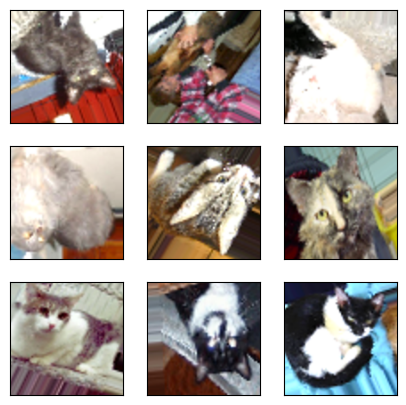

In [30]:
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))

for i in range(9):
  data = next(trainGen)
  arr = data[0][0]
  plt.subplot(3, 3, i+1)
  plt.xticks([]) # 눈금 지우기
  plt.yticks([])
  img = array_to_img(arr).resize((128, 128))
  plt.imshow(img)

plt.show()

## 이미지에 라벨링 붙이기

사진 : ['cats']
사진 : 0


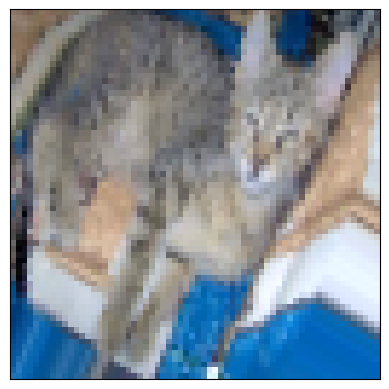

사진 : ['dogs']
사진 : 1


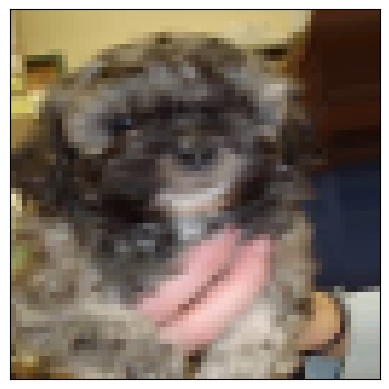

사진 : ['cats']
사진 : 0


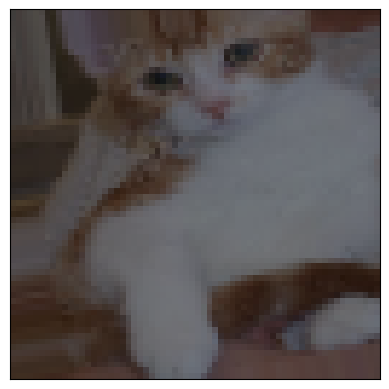

In [63]:
label_index = trainGen.class_indices

# {'cats': 0, 'dogs': 1}
x, y = trainGen.next()

for i in range(0, 3):
  image = x[i]
  label = y[i].astype('int')
  plt.xticks([]) # 눈금 지우기
  plt.yticks([])
  print('사진 : {}'.format([k for k, v in label_index.items() if v == label]))
  print('사진 : {}'.format(label))
  plt.imshow(image)
  plt.show()

## 간단한 CNN 모델 구성

In [64]:
from keras.models import Sequential
from keras import layers

model = Sequential()

model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(rate=0))

model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [65]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 input_14 (InputLayer)       multiple                  0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                 

## 모델 설정하기

In [34]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
              metrics = ['acc'])

## 모델 학습하기

In [22]:
history = model.fit(trainGen, epochs=64, validation_data=testGen)

Epoch 1/64
63/63 [==============================] - 19s 105ms/step - loss: 0.6958 - acc: 0.5255 - val_loss: 0.6804 - val_acc: 0.5150
Epoch 2/64
63/63 [==============================] - 7s 114ms/step - loss: 0.6802 - acc: 0.5595 - val_loss: 0.6697 - val_acc: 0.6370
Epoch 3/64
63/63 [==============================] - 6s 100ms/step - loss: 0.6653 - acc: 0.5890 - val_loss: 0.7473 - val_acc: 0.5070
Epoch 4/64
63/63 [==============================] - 7s 113ms/step - loss: 0.6517 - acc: 0.6295 - val_loss: 0.6217 - val_acc: 0.6610
Epoch 5/64
63/63 [==============================] - 7s 115ms/step - loss: 0.6368 - acc: 0.6370 - val_loss: 0.6547 - val_acc: 0.5780
Epoch 6/64
63/63 [==============================] - 9s 139ms/step - loss: 0.6265 - acc: 0.6440 - val_loss: 0.6077 - val_acc: 0.6620
Epoch 7/64
63/63 [==============================] - 6s 100ms/step - loss: 0.6136 - acc: 0.6520 - val_loss: 0.6264 - val_acc: 0.6430
Epoch 8/64
63/63 [==============================] - 7s 111ms/step - loss: 0

## 학습 결과 분석

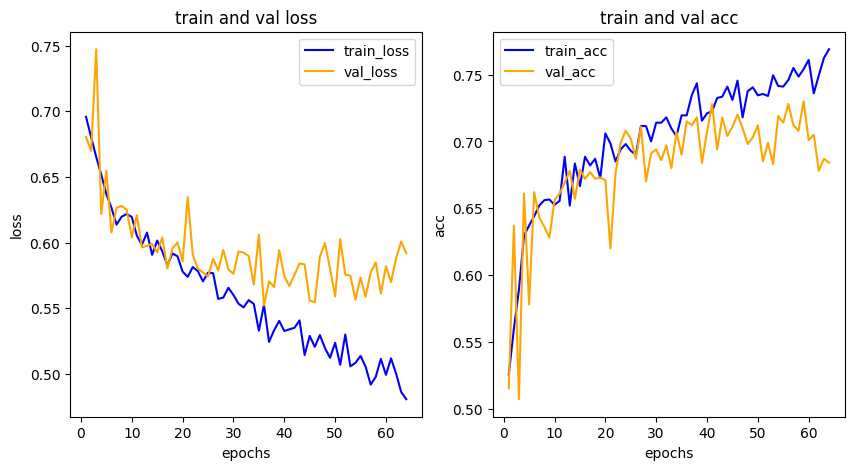

In [35]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [37]:
model.evaluate(testGen)

32/32 [==============================] - 2s 51ms/step - loss: 0.6962 - acc: 0.4970


[0.6962379217147827, 0.4970000088214874]

## 모델 예측하기

1/1 [==============================] - 0s 27ms/step
정답: 강아지  label : 1
예측: 고양이  predicted value : [[0.4670661]]


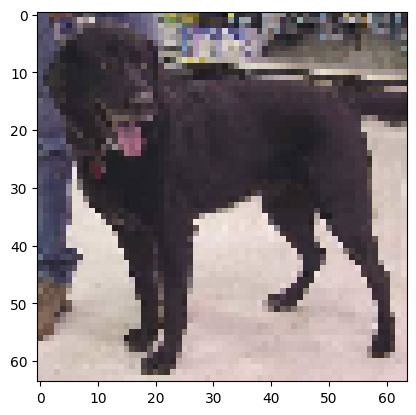

1/1 [==============================] - 0s 26ms/step
정답: 강아지  label : 1
예측: 고양이  predicted value : [[0.47172248]]


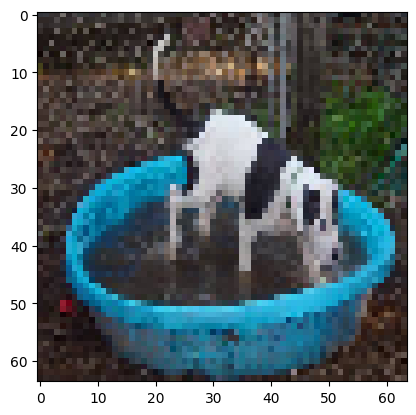

1/1 [==============================] - 0s 26ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.45669472]]


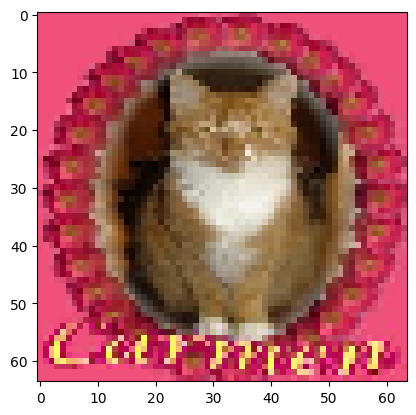

In [40]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

label_index = ['고양이', '강아지']

x, y = testGen.next()
for i in range(0,3):
  image = x[i]
  label = y[i].astype('int')

  y_prob = model.predict(image.reshape(1, 64, 64, 3))
  y_prob_class = (model.predict(image.reshape(1, 64, 64, 3)) > 0.5 ).astype('int')[0][0]
  print('정답: {}'.format(label_index[label]), ' label :', label)
  print('예측: {}'.format(label_index[y_prob_class]), ' predicted value :', y_prob)
  plt.imshow(image)
  plt.show()

## 사전학습 모델을 활용해서 예측 정확도 올리기

*   학습 데이터, 테스트 데이터 그대로 사용
*   첫번째 모델 VGG16 사용 + GlobalAveragePooling2D + Flatten() + Dense(256) + Dense(64) + Dense(1)
*   두번째 모델 ResNet50V2 사용 GlobalAveragePooling2D + Flatten() + Dense(256) + Dense(64) + Dense(1)
*   두개의 모델의 성능을 비교


In [49]:
from keras.models import Sequential
from keras.applications import VGG16
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

from keras.applications import ResNet50V2

### 첫번째 모델 VGG16 사용 + GlobalAveragePooling2D + Flatten() + Dense(256) + Dense(64) + Dense(1)

In [70]:
# 전이 학습 모델 가져오기
pre_trained_vgg16 = VGG16(input_shape=(64,64,3), include_top=False)
pre_trained_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [71]:
model1 = Sequential()
model1.add(pre_trained_vgg16)
model1.add(layers.GlobalAveragePooling2D())

model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [72]:
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                     

In [73]:
model1.compile(optimizer=Adam(1e-4),
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [74]:
history1 = model1.fit(trainGen, epochs=64, validation_data=testGen)

Epoch 1/64
63/63 [==============================] - 10s 140ms/step - loss: 0.6953 - acc: 0.5300 - val_loss: 0.6848 - val_acc: 0.5130
Epoch 2/64
63/63 [==============================] - 10s 160ms/step - loss: 0.6598 - acc: 0.6100 - val_loss: 0.6420 - val_acc: 0.6660
Epoch 3/64
63/63 [==============================] - 7s 116ms/step - loss: 0.6289 - acc: 0.6585 - val_loss: 0.5484 - val_acc: 0.7470
Epoch 4/64
63/63 [==============================] - 8s 123ms/step - loss: 0.5676 - acc: 0.7055 - val_loss: 0.4822 - val_acc: 0.7810
Epoch 5/64
63/63 [==============================] - 8s 133ms/step - loss: 0.4922 - acc: 0.7635 - val_loss: 0.4250 - val_acc: 0.8140
Epoch 6/64
63/63 [==============================] - 8s 128ms/step - loss: 0.4933 - acc: 0.7490 - val_loss: 0.3576 - val_acc: 0.8470
Epoch 7/64
63/63 [==============================] - 8s 122ms/step - loss: 0.4325 - acc: 0.7990 - val_loss: 0.3431 - val_acc: 0.8500
Epoch 8/64
63/63 [==============================] - 8s 132ms/step - loss: 

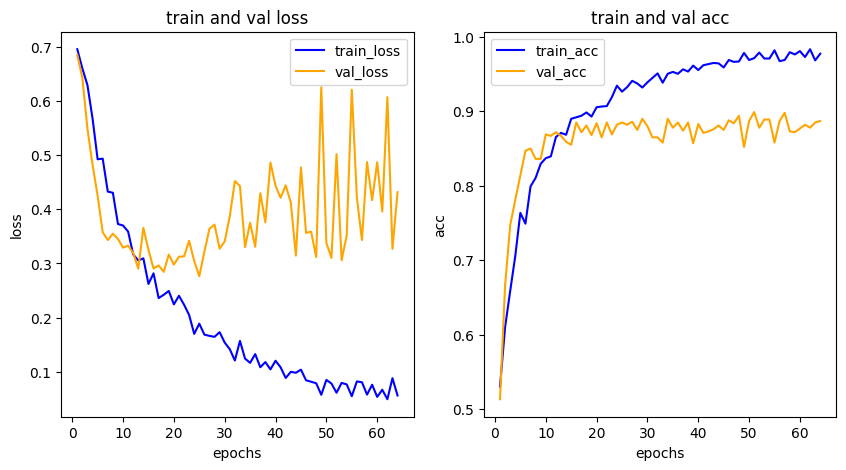

In [75]:
import matplotlib.pyplot as plt

his_dict = history1.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [76]:
model1.evaluate(testGen) #VGG16

32/32 [==============================] - 2s 47ms/step - loss: 0.4315 - acc: 0.8870


[0.4314885139465332, 0.8870000243186951]

In [79]:
model2.evaluate(testGen) #ResNet50V2

32/32 [==============================] - 4s 113ms/step - loss: 0.4768 - acc: 0.8490


[0.4767989218235016, 0.8489999771118164]

### 두번째 모델 ResNet50V 사용 GlobalAveragePooling2D + Flatten() + Dense(256) + Dense(64) + Dense(1)

In [77]:
pre_trained_resnet = ResNet50V2(input_shape=(64,64,3), include_top=False, weights='imagenet')


model2 = Sequential()

model2.add(pre_trained_resnet)
model2.add(GlobalAveragePooling2D())

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

model2.compile(optimizer = Adam(1e-4),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history2 = model2.fit( trainGen,
                    epochs = 64,
                    validation_data = testGen)

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 1)                

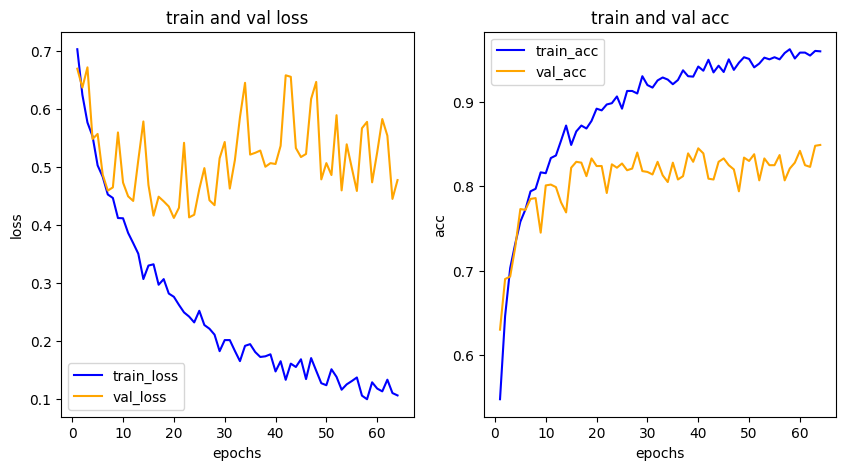

In [78]:
import matplotlib.pyplot as plt

his_dict = history2.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()